In [1]:
import json, random
from collections import Counter
import pandas as pd
import numpy as np
import networkx as nx
from itertools import islice
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Set Up Folder

In [2]:
# input
data_dir="eqa_v1"
train_file='%s/train/train.json' % data_dir
val_file='%s/val/val.json' % data_dir
cskg_dim_folder="./data/cskg_dim/cskg_dim.tsv"
wordnet_file="./data/wn/kgtk_wordnet.tsv"

# output
cskg_qa="./data/cskg_dim/eqa_cskg_dim.tsv"

# Add Triples to each lines

In [3]:
def load_source(filename):
    with open(filename,"r",encoding="utf-8") as f:
        head=f.readline().strip().split("\t")
        data=[]
        for line in f:
            temp=line.strip().split("\t")
            data.append([item.split("|")[0] for item in temp])
            
    return head, data

def k_shortest_paths(G, source, target, k, weight=None):
    return list(islice(nx.shortest_simple_paths(G, source, target, weight=weight), k))

class QAsystem():
    def __init__(self, filename):
        # add data to QAsystem
        with open(filename, 'r') as f:
            self.train=json.load(f)
        
        # build dataframe for QA system
        episodes=self.train["episodes"]

        questions=[]
        qtypes=[]
        answers=[]
        objects=[]
        for x in episodes:
            questions.append(x['question']['question_text'])
            answers.append(x['question']['answer_text'])
            qtypes.append(x['question']['question_type'])
            objects.append([x["goals"][0]["object_name"],x["goals"][0]["room_name"]])

        # build df
        data=zip(questions,answers,qtypes,objects)
        self.df=pd.DataFrame(data)
        self.df.columns=['question', 'answer', 'qtype',"objects"]
        self.df=self.df.drop_duplicates(subset=['question','answer','qtype'])
    
    def build_graph_cskg(self, source):
        # build a cskg graph
        self.G = nx.DiGraph()
        for line in source:
            self.G.add_edge(line[4].replace(" ","_"),line[5].replace(" ","_"),label=line[6],id_=line[2],source=line[8])
            
    def save_file(self, filename):
        # save file to json file
        
        question_triple=dict()
        #build dict
        for row in QA.df.iterrows():
            question_text=row[1].question
            question_triple[question_text]=[row[1].triples_len2,row[1].shortest_path]
            
        episodes=self.train["episodes"]
        for x in episodes:
            x['question']['len2Paths']=question_triple[x['question']['question_text']]
            x['question']['ShortestPath']=question_triple[x['question']['question_text']]
            
        self.train["episodes"]=episodes
        
        with open(filename, 'w') as f:
            json.dump(self.train, f)
            
    def add_cskg2QA(self):
        # add cskg to QA system
        # find object1 and object2 are in the path 2
        len2_paths=[]
        k_paths = []
        # nodes not in graph
        no_source=[]
        
        for objects in tqdm(self.df.objects):
            obj1, obj2=objects

            # check whther both nodes are in the graph. Otherwise, break
            if not self.G.has_node(obj1):
                len2_paths.append([])
                k_paths.append([])

                no_source.append(obj1)
                continue

            if not self.G.has_node(obj2):
                len2_paths.append([x['question']['question_text']])
                k_paths.append([x['question']['question_text']])

                no_source.append(obj2)
                continue
            # find a length 2 path between both nodes
            paths=[]
            paths += list(nx.all_simple_paths(self.G, source=obj1, target=obj2,cutoff=2))
            
            len2_paths.append(paths)

            # find the kth shortest path between two nodes
            temp_path=[]
            temp_path += list(k_shortest_paths(self.G, obj1, obj2, 20))

            k_paths.append(temp_path)
        self.df["triples_len2"]=len2_paths
        self.df["shortest_path"]=k_paths
        
        # filter lines
        # Choose the triples wioth relation: "r/LocatedNear","/r/AtLocation"
        id_reuqire={"/r/LocatedNear","/r/AtLocation"}

        paths_length=[]
        paths_shortest=[]
        for mult_node1, mult_node2 in zip(len2_paths,k_paths):
            items=[]
            for line in mult_node1:
                # check whether the relation in this line is the stisfied relation id
                status=True
                #print(line)
                for i in range(len(line)-1):
                    node1=line[i]
                    node2=line[i+1]
                    edge_detail = self.G[node1][node2]
                    edge_id= edge_detail["id_"]
                    #print(edge_id)
                    if edge_id in id_reuqire:
                        pass
                    else:
                        status=False
                #print(status)        
                if status:
                    new_line=[]
                    for i in range(len(line)-1):
                        node1=line[i]
                        node2=line[i+1]

                        if not new_line:
                            try:
                                new_line+=[node1,self.G[node1][node2]["label"],node2]
                            except:
                                print(node1, node2,line,line[i],line[i+1])
                        else:
                            try:
                                new_line+=[self.G[node1][node2]["label"],node2]
                            except:
                                print(node1, node2,line,line[i],line[i+1])
                else:
                    new_line=[]

                if new_line:
                    items.append(new_line)
            paths_length.append(items)

            items=[]
            for line in mult_node2:
                # check whether the relation in this line is the stisfied relation id
                status=True
                #print(line)
                for i in range(len(line)-1):
                    node1=line[i]
                    node2=line[i+1]
                    edge_detail = self.G[node1][node2]
                    edge_id= edge_detail["id_"]
                    #print(edge_id)
                    if edge_id in id_reuqire:
                        pass
                    else:
                        status=False
                #print(status)        
                if status:
                    new_line=[]
                    for i in range(len(line)-1):
                        node1=line[i]
                        node2=line[i+1]

                        if not new_line:
                            try:
                                new_line+=[node1,self.G[node1][node2]["label"],node2]
                            except:
                                print(node1, node2,line,line[i],line[i+1])
                        else:
                            try:
                                new_line+=[self.G[node1][node2]["label"],node2]
                            except:
                                print(node1, node2,line,line[i],line[i+1])
                else:
                    new_line=[]

                if new_line:
                    items.append(new_line)
            paths_shortest.append(items)
        
        # filter by label

        # build relation id to relation label dictionary
        relation_label=dict()
        for node1, node2 in self.G.edges:
            edge_detail=self.G[node1][node2]
            rel_id=edge_detail['id_']

            if rel_id in id_reuqire:
                temp=relation_label.get(rel_id,dict())

                label=edge_detail["label"]
                temp[label]=temp.get(label,0)+1
                relation_label[rel_id]=temp

        # choose the top 20 frequency relation and each relation label should also take 5%
        # check total number of triples for different relation id
        num_rel_id=dict()
        for rel_id in relation_label:
            num_rel_id[rel_id]=sum(relation_label[rel_id].values())
        
        relation_label_sort=dict()
        for rel_id in relation_label:
            label_num=relation_label[rel_id]
            sort_label = sorted(label_num.items(),key=lambda k:k[1], reverse=True)

            for label, num in sort_label[:20]:
                if num >= num_rel_id[rel_id]*0.01:
                    temp=relation_label_sort.get(rel_id, dict())
                    temp[label]=num
                    relation_label_sort[rel_id]=temp
        
        allowed_label=[]
        for key_ in relation_label_sort:
            allowed_label += list(relation_label_sort[key_])

        filtered_paths_length=[]
        for path_combine in paths_length:
            temp=[]
            for path in path_combine:
                length = len(path)
                relation_num = length//2

                count = 1
                pos= count*2-1
                status = True
                while pos < length:
                    rel_label= path[pos]

                    if rel_label not in allowed_label:
                        status = False
                        break

                    count+=1
                    pos= count*2-1

                if status:
                    temp.append(path)

            filtered_paths_length.append(temp)
        
        filtered_paths_shortest=[]
        for path_combine in paths_shortest:
            temp=[]
            for path in path_combine:
                length = len(path)
                relation_num = length//2

                count = 1
                pos= count*2-1
                status = True
                while pos < length:
                    rel_label= path[pos]

                    if rel_label not in allowed_label:
                        status = False
                        break

                    count+=1
                    pos= count*2-1

                if status:
                    temp.append(path)

            filtered_paths_shortest.append(temp)
            
        self.df["triples_len2"]=filtered_paths_length
        self.df["shortest_path"]=filtered_paths_shortest
        return self.df

In [4]:
# load cskg_dim
cskg_dim_head,cskg_dim_lines=load_source(cskg_dim_folder)
cskg_dim_lines[0]

['/c/en/0-/r/DefinedAs-/c/en/empty_set-0000',
 '/c/en/0',
 '/r/DefinedAs',
 '/c/en/empty_set',
 '0',
 'empty set',
 'defined as',
 'similarity',
 'CN',
 '[[0]] is the [[empty set]].']

# load train dataset

In [5]:
# load original data
QA=QAsystem(train_file)

In [6]:
QA.build_graph_cskg(cskg_dim_lines)

In [7]:
QA.add_cskg2QA()

100%|██████████| 471/471 [00:05<00:00, 89.44it/s] 


,question,answer,qtype,objects,triples_len2,shortest_path
0,what color is the cabinet in the kitchen?,black,color_room,"[cabinet, kitchen]","[[cabinet, on top of, counter, by, kitchen], [...","[[cabinet, in, kitchen], [cabinet, above, cat,..."
1,what color is the picture in the office?,brown,color_room,"[picture, office]","[[picture, above, train, has, office], [pictur...","[[picture, above, train, has, office], [pictur..."
2,what color is the sofa in the family room?,off-white,color_room,"[sofa, family_room]",[],"[[sofa, next to, basket, behind, cat, at locat..."
3,what color is the curtain in the hallway?,off-white,color_room,"[curtain, hallway]","[[curtain, has, edge, of, hallway], [curtain, ...","[[curtain, has, edge, of, hallway], [curtain, ..."
4,what color is the door in the closet?,white,color_room,"[door, closet]","[[door, has a, handle, of, closet], [door, in,...","[[door, in, back, of, closet], [door, behind, ..."
...,...,...,...,...,...,...
11268,what color is the table in the bedroom?,tan,color_room,"[table, bedroom]","[[table, in, floor, in, bedroom], [table, in, ...","[[table, in, bedroom], [table, behind, baby, i..."
11369,what color is the stool in the lounge?,tan,color_room,"[stool, lounge]",[],[]
11370,what color is the stool?,tan,color,"[stool, lounge]",[],[]
11398,what room is the stool located in?,lounge,location,"[stool, lounge]",[],[]


In [8]:
QA.save_file(train_file)

Text(0, 0.5, 'Number of Question')

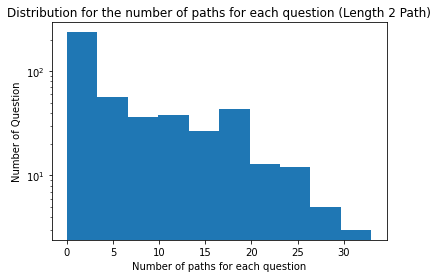

In [10]:
a=plt.hist([len(_) for _ in QA.df["triples_len2"]],log=True)
plt.title('Distribution for the number of paths for each question (Length 2 Path)')
plt.xlabel('Number of paths for each question')
plt.ylabel('Number of Question')

Text(0, 0.5, 'Number of Question')

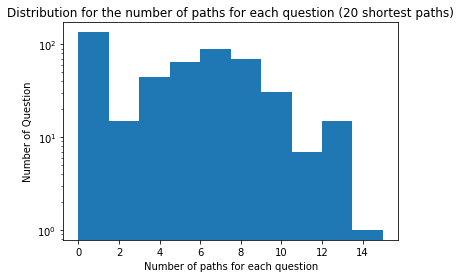

In [11]:
a=plt.hist([len(_) for _ in QA.df["shortest_path"]],log=True)
plt.title('Distribution for the number of paths for each question (20 shortest paths)')
plt.xlabel('Number of paths for each question')
plt.ylabel('Number of Question')

In [12]:
# count missing answer
print("length 2 path:",sum([len(_)==0 for _ in QA.df["triples_len2"]]))
print("shortest path:",sum([len(_)==0 for _ in QA.df["shortest_path"]]))

length 2 path: 168
shortest path: 77


# Discard Room in Z position

In [13]:
# check the room name in EQA

rooms=set()
for object_, room in QA.df.objects:
    rooms.add(room)

In [14]:
# romove room Z, has
triples_len2_new=[]
shortest_path_new=[]

for triples1, triples2 in zip(QA.df.triples_len2, QA.df.shortest_path):
    new_triples1=[]
    new_triples2=[]
    
    for triple in triples1:
        if triple[2] in rooms or "room" in triple[2]:
            # romve room in Z position
            continue
            
        elif "has" in triple[1] or "has" in triple[3]:
            # romve "has" in relation
            continue
            
        else:
            new_triples1.append(triple)
            
    for triple in triples2:
        if triple[2] in rooms or "room" in triple[2]:
            continue
        else:
            new_triples2.append(triple)
            
    triples_len2_new.append(new_triples1)
    shortest_path_new.append(new_triples2)
    
QA.df["triples_len2"]=triples_len2_new
QA.df["shortest_path"]=shortest_path_new

# Build Wordnet Ontology

In [15]:
# build wordnet ontology
# load wordnet
wordnet_head,wordnet_lines=load_source(wordnet_file)
wordnet_lines[0]

['wn:physical_entity.n.01',
 '/r/IsA',
 'wn:entity.n.01',
 '"physical entity"',
 '"entity"',
 '"is a"',
 '',
 '"WN"']

In [16]:
# build graph
wordnet_g=nx.DiGraph()

In [17]:
id2label=defaultdict(set)

for line in wordnet_lines:
    if line[1]== "/r/IsA":
        node1=line[0].split(":")[1]
        node2=line[2].split(":")[1]
        node1_labels=line[3].replace('"',"").split("|")
        node2_labels=line[4].replace('"',"").split("|")
        id2label[node1]=id2label[node1].union(node1_labels)
        id2label[node2]=id2label[node2].union(node2_labels)
        
        if ".v." in node1 or ".v." in node1:
            continue
        wordnet_g.add_edge(node1,node2)
    else:
        continue

In [18]:
# check the top level node
start_node=set()

for node in wordnet_g.nodes:
    if wordnet_g.out_degree(node)==0:
        start_node.add(node)

In [19]:
start_node

{'channel_island.n.01',
 'entity.n.01',
 'fury.n.04',
 'godhead.n.01',
 'magellanic_cloud.n.01',
 'mediterranean.n.01',
 'protagonist.n.02',
 'south.n.01',
 'spain.n.01',
 'titan.n.02',
 'united_kingdom.n.01',
 'west_indies.n.01'}

In [20]:
black_list={"room.n.02",'room.n.01',"food.n.01",'animal.n.01','person.n.01'}
new_black_list=set()
# check all sub class of blacklist

for item in black_list:
    temp=[item]
    while temp:
        new_temp=[]
        for issue in temp:
            new_temp+=[edge[0] for edge in wordnet_g.in_edges(issue)]
            
        new_temp_set=set(new_temp)
        new_black_list=new_black_list.union(new_temp_set)
        temp=new_temp_set
    

In [21]:
# check the blacklist label
blacklist_label=set()

for id_ in new_black_list:
    blacklist_label=blacklist_label.union(id2label[id_])

In [23]:
# filter by blacklist_label:
triples_len2_new=[]
shortest_path_new=[]
count=0

for triples1, triples2 in zip(QA.df.triples_len2, QA.df.shortest_path):
    new_triples1=[]
    new_triples2=[]
    
    for triple in triples1:
        if triple[2] in blacklist_label:
            count +=1
            continue
            
        else:
            new_triples1.append(triple)
            
    for triple in triples2:
        if triple[2] in blacklist_label:
            count +=1
            continue
        else:
            new_triples2.append(triple)
            
    triples_len2_new.append(new_triples1)
    shortest_path_new.append(new_triples2)

In [24]:
"girl" in blacklist_label

True

In [25]:
QA.df["triples_len2"]=triples_len2_new
QA.df["shortest_path"]=shortest_path_new
QA.df

,question,answer,qtype,objects,triples_len2,shortest_path
0,what color is the cabinet in the kitchen?,black,color_room,"[cabinet, kitchen]","[[cabinet, for, food, in, kitchen], [cabinet, ...","[[cabinet, with, coffee_maker, in, kitchen]]"
1,what color is the picture in the office?,brown,color_room,"[picture, office]","[[picture, in, notebook, at location, office]]","[[picture, above, train, has, office], [pictur..."
2,what color is the sofa in the family room?,off-white,color_room,"[sofa, family_room]",[],"[[sofa, next to, basket, behind, cat, at locat..."
3,what color is the curtain in the hallway?,off-white,color_room,"[curtain, hallway]","[[curtain, in, mirror, in, hallway], [curtain,...","[[curtain, has, edge, of, hallway], [curtain, ..."
4,what color is the door in the closet?,white,color_room,"[door, closet]","[[door, behind, bar, in, closet], [door, on, b...","[[door, behind, bar, in, closet], [door, on, b..."
...,...,...,...,...,...,...
11268,what color is the table in the bedroom?,tan,color_room,"[table, bedroom]","[[table, at location, corner, in, bedroom], [t...","[[table, near, bookshelf, at location, bedroom..."
11369,what color is the stool in the lounge?,tan,color_room,"[stool, lounge]",[],[]
11370,what color is the stool?,tan,color,"[stool, lounge]",[],[]
11398,what room is the stool located in?,lounge,location,"[stool, lounge]",[],[]


In [26]:
triples_len2_new[0]

[['cabinet', 'for', 'food', 'in', 'kitchen'],
 ['cabinet', 'with', 'coffee_maker', 'in', 'kitchen'],
 ['cabinet', 'above', 'fridge', 'at location', 'kitchen'],
 ['cabinet', 'above', 'microwave_oven', 'at location', 'kitchen'],
 ['cabinet', 'near', 'paper_towels', 'in', 'kitchen'],
 ['cabinet', 'above', 'trash', 'at location', 'kitchen'],
 ['cabinet', 'behind', 'desk', 'in', 'kitchen']]

In [27]:
# count missing answer
print("length 2 path:",sum([len(_)==0 for _ in QA.df["triples_len2"]]))
print("shortest path:",sum([len(_)==0 for _ in QA.df["shortest_path"]]))

length 2 path: 208
shortest path: 121


# combine original question

In [28]:
def score(tokens_tensor):
    loss=model(tokens_tensor, labels=tokens_tensor)[0]
    return np.exp(loss.cpu().detach().numpy())

In [29]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [30]:
# check the average answer
count1=0
count2=0
sum_1=[]
sum_2=[]
for triples1, triples2 in zip(QA.df.triples_len2, QA.df.shortest_path):
    if len(triples1)>0:
        count1+=1
        
    if len(triples2)>0:
        count2+=1
    sum_1.append(len(triples1))
    sum_2.append(len(triples2))
    
print(sum(sum_1)/count1,sum(sum_2)/count2)

5.357414448669202 4.1571428571428575


In [31]:
# build new sentence
num_choice=5
new_sentence=[]

for row in QA.df.iterrows():
    line=row[1]
    question_text=line.question
    object_=line.objects[0].replace("_"," ").replace("#"," ")
    
    question_templet=question_text.split(object_)[0]+object_+", which can be"
    question_templet2=question_text.split(object_)[1]
    
    more_item=""
    
    if not line.triples_len2:
        #new_sentence.append("")
        continue
    
    if len(line.triples_len2)>num_choice:
        triples=random.sample(line.triples_len2,num_choice)
    else:
        triples=line.triples_len2
    
    for triple in triples:
        relation=triple[1]
        item= triple[2]
        if not more_item:
            more_item+=relation + " a "+ item
        else:
            more_item += " or "+ relation+" a "+item
            
    sent=question_templet+" "+more_item+","+question_templet2
    sent.replace("_"," ").replace("?"," ")
    if sent[-2]==",":
        sent=sent[:-2]+"?"
    new_sentence.append(sent)

In [32]:
new_sentence_set= set(new_sentence)

In [33]:
sentence_score=[]

for sent in new_sentence_set:
    tokens_tensor = tokenizer.encode(sent, add_special_tokens=False, return_tensors="pt")
    result_score=score(tokens_tensor)
    sentence_score.append([sent,result_score])

# load val dataset

In [34]:
QA=QAsystem(val_file)
QA.build_graph_cskg(cskg_dim_lines)
QA.add_cskg2QA()

100%|██████████| 114/114 [00:01<00:00, 85.24it/s]


,question,answer,qtype,objects,triples_len2,shortest_path
0,what color is the picture in the closet?,brown,color_room,"[picture, closet]","[[picture, on top of, bar, in, closet], [pictu...","[[picture, on top of, bar, in, closet], [pictu..."
8,what color is the shelving in the hallway?,brown,color_room,"[shelving, hallway]",[],[]
13,what color is the door in the office?,white,color_room,"[door, office]","[[door, above, building, has, office], [door, ...","[[door, by, office], [door, above, building, h..."
22,what color is the door in the closet?,brown,color_room,"[door, closet]","[[door, has a, handle, of, closet], [door, in,...","[[door, in, back, of, closet], [door, behind, ..."
24,what color is the curtain in the bathroom?,off-white,color_room,"[curtain, bathroom]","[[curtain, has a, house, has a, bathroom], [cu...","[[curtain, behind, clock, in, bathroom], [curt..."
...,...,...,...,...,...,...
1805,what room is the wardrobe located in?,gym,location,"[wardrobe, gym]",[],[]
1826,what room is the tv stand located in?,family room,location,"[tv#stand, family_room]",[],[]
1852,what color is the cabinet in the bedroom?,brown,color_room,"[cabinet, bedroom]","[[cabinet, above, television, in, bedroom], [c...","[[cabinet, in, bedroom], [cabinet, in, backgro..."
1855,what color is the clothes dryer?,white,color,"[clothes#dryer, laundry_room]",[],[]


In [35]:
QA.save_file(val_file)

# check the room name in EQA

rooms=set()
for object_, room in QA.df.objects:
    rooms.add(room)
    
# romove room Z, has
triples_len2_new=[]
shortest_path_new=[]

for triples1, triples2 in zip(QA.df.triples_len2, QA.df.shortest_path):
    new_triples1=[]
    new_triples2=[]
    
    for triple in triples1:
        if triple[2] in rooms or "room" in triple[2]:
            # romve room in Z position
            continue
            
        elif "has" in triple[1] or "has" in triple[3]:
            # romve "has" in relation
            continue
            
        else:
            new_triples1.append(triple)
            
    for triple in triples2:
        if triple[2] in rooms or "room" in triple[2]:
            continue
        else:
            new_triples2.append(triple)
            
    triples_len2_new.append(new_triples1)
    shortest_path_new.append(new_triples2)
    
QA.df["triples_len2"]=triples_len2_new
QA.df["shortest_path"]=shortest_path_new


# filter by blacklist_label:
triples_len2_new=[]
shortest_path_new=[]
count=0

for triples1, triples2 in zip(QA.df.triples_len2, QA.df.shortest_path):
    new_triples1=[]
    new_triples2=[]
    
    for triple in triples1:
        if triple[2] in blacklist_label:
            count +=1
            continue
            
        else:
            new_triples1.append(triple)
            
    for triple in triples2:
        if triple[2] in blacklist_label:
            count +=1
            continue
        else:
            new_triples2.append(triple)
            
    triples_len2_new.append(new_triples1)
    shortest_path_new.append(new_triples2)

In [36]:
# check the average answer
count1=0
count2=0
sum_1=[]
sum_2=[]
for triples1, triples2 in zip(QA.df.triples_len2, QA.df.shortest_path):
    if len(triples1)>0:
        count1+=1
        
    if len(triples2)>0:
        count2+=1
    sum_1.append(len(triples1))
    sum_2.append(len(triples2))
    
print(sum(sum_1)/count1,sum(sum_2)/count2)

8.044776119402986 5.511627906976744


In [37]:
# build new sentence
num_choice=5
new_sentence=[]


for row in QA.df.iterrows():
    line=row[1]
    question_text=line.question
    object_=line.objects[0].replace("_"," ").replace("#"," ")
    
    question_templet=question_text.split(object_)[0]+object_+", which can be"
    question_templet2=question_text.split(object_)[1]
    
    more_item=""
    
    if not line.triples_len2:
        #new_sentence.append("")
        continue
    
    if len(line.triples_len2)>num_choice:
        triples=random.sample(line.triples_len2,num_choice)
    else:
        triples=line.triples_len2
    
    for triple in triples:
        relation=triple[1]
        item= triple[2]
        if not more_item:
            more_item+=relation + " a "+ item
        else:
            more_item += " or "+ relation+" a "+item
            
    sent=question_templet+" "+more_item+","+question_templet2
    sent.replace("_"," ").replace("?"," ")
    if sent[-2]==",":
        sent=sent[:-2]+"?"
    new_sentence.append(sent)

In [38]:
len(new_sentence)

67

In [39]:
new_sentence_set=new_sentence_set.union(set(new_sentence))

In [40]:
sentence_score=[]

for sent in new_sentence_set:
    tokens_tensor = tokenizer.encode(sent, add_special_tokens=False, return_tensors="pt")
    result_score=score(tokens_tensor)
    sentence_score.append([sent,result_score])

In [45]:
sort_sentence_score=sorted(sentence_score,key=lambda k:int(k[1]))
sort_sentence_score[:10]

[['what color is the stove, which can be in a countertop or near a dishwasher or in a corner or next to a fridge or next to a child, in the kitchen?',
  31.765287],
 ['what color is the towel, which can be for a bath or on top of a ladder or on a mat or on a bowl or in a photo, in the bathroom?',
  35.519028],
 ['what color is the refrigerator, which can be behind a counter or next to a countertop or next to a dishwasher or in a stack or behind a woman?',
  36.45261],
 ['what color is the curtain, which can be in a mirror or behind a lamp or by a bedspread or behind a couch or by a shelf?',
  36.517555],
 ['what color is the toaster, which can be in a corner or next to a pan or next to a container or above a cabinet or on a dryer?',
  36.666138],
 ['what color is the curtain, which can be in a mirror or behind a desk or next to a fridge or in a image or in a photo, in the kitchen?',
  36.486702],
 ['what color is the stove, which can be in a countertop or in a back or in a corner or on

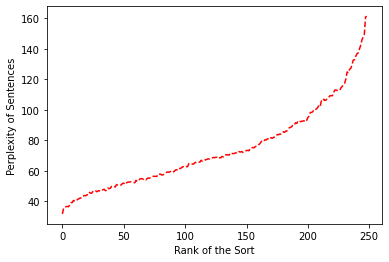

In [42]:
# draw a score graph
y=[_[1] for _ in sort_sentence_score]
x= range(len(sort_sentence_score))

plt.xlabel('Rank of the Sort')
plt.ylabel('Perplexity of Sentences')
plt.plot(x,y,'r--',label='type1')

In [43]:
tokens_tensor = tokenizer.encode('what color is the counter, which is in the area or next to microwave?', add_special_tokens=False, return_tensors="pt")
result_score=score(tokens_tensor)
result_score

151.79474

In [44]:
sort_sentence_score[-10:]

[['what color is the table, which can be in a image or for a cover or at location a corner or behind a friends or near a grill, in the kitchen?',
  135.02672],
 ['what color is the counter, which can be of a bar or under a medicine_cabinet?',
  136.68172],
 ['what color is the table, which can be near a window_pane or with a sign or for a art or at location a building or near a ceiling, in the bathroom?',
  137.24886],
 ['what color is the cabinet, which can be above a microwave_oven or for a food or behind a desk or above a fridge or with a coffee_maker, in the kitchen?',
  139.65775],
 ['what color is the table, which can be at location a corner or for a luggage or near a ceiling, in the hallway?',
  142.19083],
 ['what room is the shower, which can be for a toilet_seat or in a background or next to a tank, located in?',
  145.7018],
 ['what color is the table, which can be with a presents or behind a couple or on a balcony or at location a rug or with a lamp_shade, in the living roo